# Weed Detection in Soybean Crops

## Import Dataset from Kaggle

In [33]:
# Install Kaggle to get Dataset
!pip install kaggle

In [1]:
!mkdir .kaggle
!mkdir ~/.kaggle

import shutil
shutil.move('/content/kaggle.json', '/content/.kaggle/kaggle.json')

'/content/.kaggle/kaggle.json'

In [2]:
import json

token = {"username":"xxxxxxxxx","key":"xxxxxxxxxxxxxxxx"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

- path is now set to: {/content}


In [3]:
# Download the soybean crops dataset
!kaggle datasets download -d fpeccia/weed-detection-in-soybean-crops

 99% 2.34G/2.37G [00:48<00:00, 27.4MB/s]
100% 2.37G/2.37G [00:48<00:00, 52.6MB/s]


In [0]:
!unzip '/content/{/content}/datasets/fpeccia/weed-detection-in-soybean-crops/weed-detection-in-soybean-crops.zip'

## Code

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split

import seaborn as sns

import os, glob, cv2, random

### Explore the data

In [0]:
# Print the amount of data
def count_cases(data_dir):
    subdirs = os.listdir(data_dir)

    subdir_names = []
    subdir_file_count = []

    for subdir in subdirs:
        current_dir = os.path.join(data_dir, subdir)
        file_count = len(os.listdir(current_dir))
        subdir_names.append(subdir)
        subdir_file_count.append(file_count)
    
    return subdir_names, subdir_file_count
    
def make_bar_plot(data_dir, title, subplot_num):
    x, y = count_cases(data_dir)
    plt.subplot(subplot_num)
    sns.barplot(x=x, y=y)
    plt.title(title)
    plt.xticks(range(len(x)), x)

def show_file_count(data_dir):
    plt.figure(figsize=(20,8))
    
    title = 'Data'
    subplot_num = 131
    make_bar_plot(data_dir, title, subplot_num)
    
    plt.show()

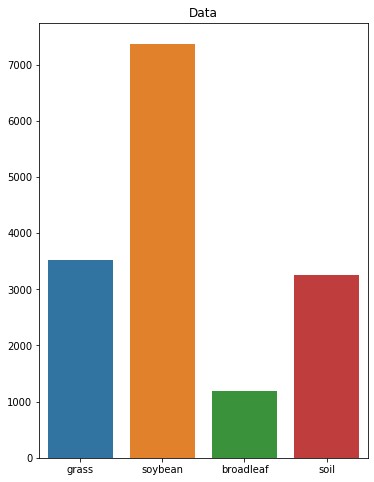

broadleaf size: 1191
grass size: 3520
soil size: 3249
soybean size: 7376


In [7]:
data_dir = './dataset/dataset/'
classes = ['broadleaf', 'grass', 'soil', 'soybean']

show_file_count(data_dir)

broadleaf_dir = os.path.join(data_dir, classes[0])
grass_dir = os.path.join(data_dir, classes[1])
soil_dir = os.path.join(data_dir, classes[2])
soybean_dir = os.path.join(data_dir, classes[3])

class_paths = [broadleaf_dir, grass_dir, soil_dir, soybean_dir]

broadleaf_files = os.listdir(broadleaf_dir)
grass_files = os.listdir(grass_dir)
soil_files = os.listdir(soil_dir)
soybean_files = os.listdir(soybean_dir)

print('broadleaf size: ' + str(len(broadleaf_files)))
print('grass size: ' + str(len(grass_files)))
print('soil size: ' + str(len(soil_files)))
print('soybean size: ' + str(len(soybean_files)))

In [0]:
# Function to print images
def print_imgs(path, img_to_print, figsize=(16, 6)):
    fig = plt.figure(figsize=figsize)
    img_printed = 0
    for file in os.listdir(path):
        if img_printed == img_to_print:
            break
        
        img = mpimg.imread(os.path.join(path, file))
        plt.title(file)
        plt.subplot(2, img_to_print/2, img_printed+1)
        img_plot = plt.imshow(img)
        img_printed += 1

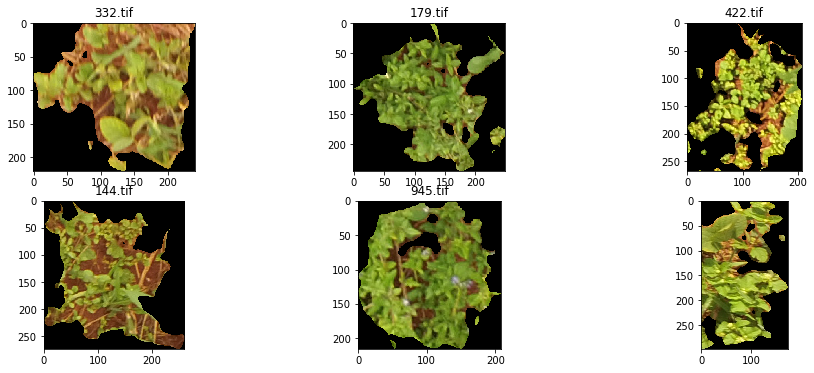

In [43]:
# Print broadleaf images
print_imgs(broadleaf_dir, 6)

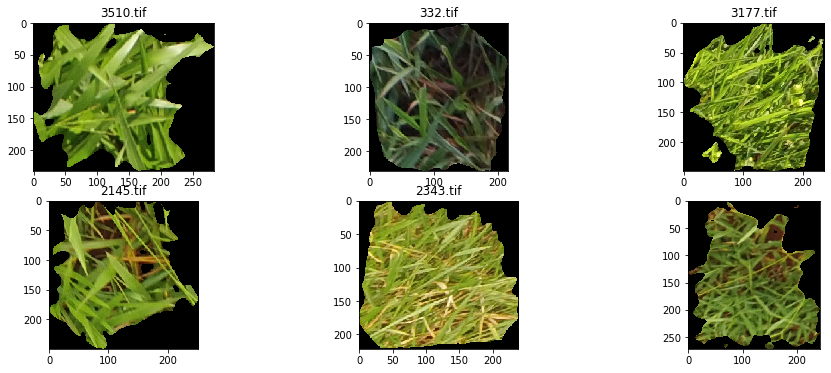

In [44]:
# Print grass images
print_imgs(grass_dir, 6)

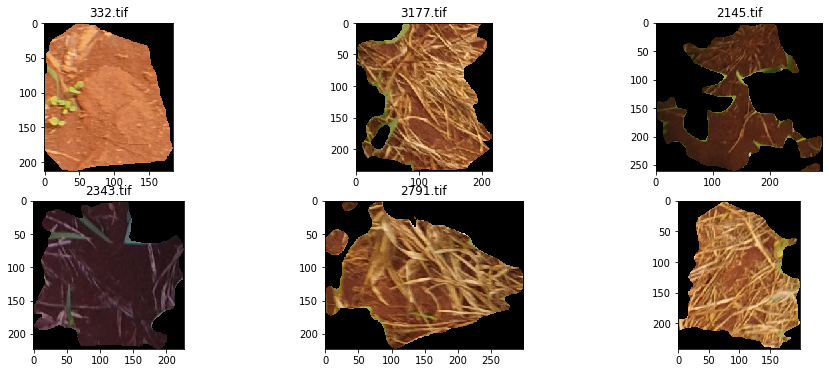

In [45]:
# Print soil images
print_imgs(soil_dir, 6)

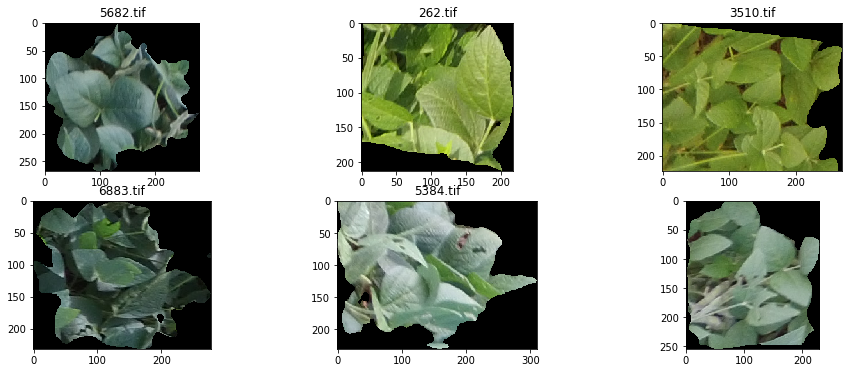

In [46]:
# Print soybean images
print_imgs(soybean_dir, 6)

In [0]:
# Delete unused folders
!rm -rf 'dataset/broadleaf'
!rm -rf 'dataset/grass'
!rm -rf 'dataset/soil'
!rm -rf 'dataset/soybean'
!rm -rf {

### Preprocess data

In [0]:
cant_files = 1100
cant_train = 1000
cant_val = 50
cant_test = 50

all_files = [] 
num_data = cant_files * len(classes)
y = np.zeros(num_data)

for i, c in enumerate(classes):
    all_files += [f for f in glob.glob(data_dir + c + '/*.tif')][:cant_files]
    y[i * cant_files : (i + 1) * cant_files] = i

In [0]:
# Image dimension
width = 230
height = 230
channel = 3
dim = width * height * channel

X = np.ndarray(shape=(num_data, width, height, channel), dtype=np.float64)

for i, img_file in enumerate(all_files):
    X[i] = cv2.resize(cv2.imread(img_file), (width, height))

X_train = np.empty(shape=(cant_train * len(classes), width, height, channel), dtype=np.float64)
X_val = np.empty(shape=(cant_val * len(classes), width, height, channel), dtype=np.float64)
X_test = np.empty(shape=(cant_test * len(classes), width, height, channel), dtype=np.float64)

y_train = np.empty(cant_train * len(classes))
y_val = np.empty(cant_val * len(classes))
y_test = np.empty(cant_test * len(classes)) 

for i, c in enumerate(classes): 
    X_test[cant_test * i : cant_test * (i + 1)] = X[np.where(y == i)[0][:cant_test]]
    X_val[cant_val * i : cant_val * (i + 1)] = X[np.where(y == i)[0][cant_test:cant_test + cant_val]]
    X_train[cant_train * i : cant_train * (i + 1)] = X[np.where(y == i)[0][cant_test + cant_val:]]
    
    y_test[cant_test * i : cant_test * (i + 1)] = i
    y_val[cant_val * i : cant_val * (i + 1)] = i
    y_train[cant_train * i : cant_train * (i + 1)] = i

del y
del X

In [18]:
train_idxs = np.random.permutation(X_train.shape[0])
y_train  = y_train[train_idxs].astype(int)
X_train = X_train[train_idxs]

X_train = np.reshape(X_train, (X_train.shape[0], -1)).astype('float64')
X_test = np.reshape(X_test, (X_test.shape[0], -1)).astype('float64')
X_val = np.reshape(X_val, (X_val.shape[0], -1)).astype('float64')

X_tiny = X_train[100:110].astype('float64')
y_tiny = y_train[100:110].astype(int)
cant_dev = 500

X_dev = X_train[0:cant_dev].astype('float64')
y_dev = y_train[0:cant_dev].astype(int)
print("X_train shape", X_train.shape, "- y_train shape:", y_train.shape)
print("X_test shape", X_test.shape, "- y_test shape:", y_test.shape)
print("X_val shape", X_val.shape, "- y_val shape:", y_val.shape)
print("X_dev shape", X_dev.shape, "- y_dev shape:", y_dev.shape)
print("X_tiny shape", X_tiny.shape, "-| y_tiny shape:", y_tiny.shape)

mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image 
X_test -= mean_image
X_dev -= mean_image
X_tiny -= mean_image

print(' ')
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("X_val shape", X_val.shape)
print("X_dev shape", X_dev.shape)
print("X_tiny shape", X_tiny.shape)

X_train shape (4000, 158700) - y_train shape: (4000,)
X_test shape (200, 158700) - y_test shape: (200,)
X_val shape (200, 158700) - y_val shape: (200,)
X_dev shape (500, 158700) - y_dev shape: (500,)
X_tiny shape (10, 158700) -| y_tiny shape: (10,)
 
X_train shape (4000, 158700)
X_test shape (200, 158700)
X_val shape (200, 158700)
X_dev shape (500, 158700)
X_tiny shape (10, 158700)


## Two Layer NN

In [0]:
# Source https://www.kaggle.com/datduyn/2-layer-net-on-weeds-discriminant/
class TwoLayerNN():
    def __init__(self, input_size, hidden_size, output_size, std= 1e-4):
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def loss(self, X, y = None, reg=0.0):
        relu = lambda x:np.maximum(0,x)

        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        N, D = X.shape
        layer1 = relu(X.dot(W1) + b1)
        scores = layer1.dot(W2) + b2

        if(y is None):
            return scores

        scores -= scores.max()

        scores = np.exp(scores)
        scores_sumexp = np.sum(scores, axis=1)

        softmax = scores / scores_sumexp.reshape(N,1)

        loss =  (-1.0) * np.sum(np.log(softmax[range(N),y]))
        loss /= N
        loss += reg * np.sum(W1 * W1)
        loss += reg * np.sum(W2 * W2)

        grads = {}

        correct_class_scores = scores[range(N), y]
        softmax[range(N), y] = (-1.0) * (scores_sumexp - correct_class_scores)/scores_sumexp
        softmax /= N

        grads['W2'] = layer1.T.dot(softmax)
        grads['b2'] = np.sum(softmax, axis=0)
        grads['W2'] += reg * 2 * W2

        hidden = softmax.dot(W2.T)

        hidden[layer1 == 0] = 0

        grads['W1'] = X.T.dot(hidden)
        grads['b1'] = np.sum(hidden, axis=0)
        grads['W1'] += reg * 2 * W1

        return loss, grads

    def train(self, X, y, X_val, y_val, learning_rate =1e-3, learning_rate_decay=0.95, 
              reg=5e-6, num_iters=100, batch_size=200, it_verbose = 1, verbose=False):
        
        N, D = X.shape
        N_val = X_val.shape[0]
        iteration_per_epoch = max(N/batch_size, 1)
        
        loss_hist = []
        train_acc_hist = []
        val_acc_hist = []
        
        for it in range(num_iters):
            sampling = np.random.choice(np.arange(N), batch_size, replace=False)
            X_batch = X[sampling]
            y_batch = y[sampling]
            
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_hist.append(loss)
        
            self.params['W1'] += (-1.0) * learning_rate * grads['W1']
            self.params['b1'] += (-1.0) * learning_rate * grads['b1']
            self.params['W2'] += (-1.0) * learning_rate * grads['W2']
            self.params['b2'] += (-1.0) * learning_rate * grads['b2']
            
            if(verbose and it%it_verbose==0):
                print('iteration: %d / %d | Loss: %f' % (it, num_iters, loss))
            
            if (it % iteration_per_epoch == 0):
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_hist.append(train_acc)
                val_acc_hist.append(val_acc)

                learning_rate *= learning_rate_decay
        return {
            'loss_hist':loss_hist,
            'train_acc_hist':train_acc_hist,
            'val_acc_hist':val_acc_hist
        }

    def predict(self, X):
        y_pred = None
        relu = lambda x:np.maximum(0,x)
        
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        layer1 = relu(X.dot(W1) + b1)
        scores = layer1.dot(W2) + b2
        y_pred = np.argmax(scores, axis=1)

        return y_pred

In [25]:
in_size = width * height * channel
hidden_size = 200
out_size = len(classes)
std = 1e-3

model = TwoLayerNN(in_size, hidden_size, out_size,std)

history_data = model.train(X_train, y_train, X_val, y_val, 
              learning_rate=1e-5, learning_rate_decay=0.95, 
              reg=0.0, num_iters=400, 
              batch_size=100, it_verbose = 10, verbose=True)

iteration: 0 / 400 | Loss: 1.406687
iteration: 10 / 400 | Loss: 1.351234
iteration: 20 / 400 | Loss: 1.275516
iteration: 30 / 400 | Loss: 1.268149
iteration: 40 / 400 | Loss: 1.236547
iteration: 50 / 400 | Loss: 1.162658
iteration: 60 / 400 | Loss: 1.166442
iteration: 70 / 400 | Loss: 1.098283
iteration: 80 / 400 | Loss: 1.127953
iteration: 90 / 400 | Loss: 1.004515
iteration: 100 / 400 | Loss: 1.055686
iteration: 110 / 400 | Loss: 0.995276
iteration: 120 / 400 | Loss: 0.959147
iteration: 130 / 400 | Loss: 0.968260
iteration: 140 / 400 | Loss: 0.955374
iteration: 150 / 400 | Loss: 0.822525
iteration: 160 / 400 | Loss: 0.915033
iteration: 170 / 400 | Loss: 0.818532
iteration: 180 / 400 | Loss: 0.881597
iteration: 190 / 400 | Loss: 0.772010
iteration: 200 / 400 | Loss: 0.878954
iteration: 210 / 400 | Loss: 0.803405
iteration: 220 / 400 | Loss: 0.856114
iteration: 230 / 400 | Loss: 0.849836
iteration: 240 / 400 | Loss: 0.783375
iteration: 250 / 400 | Loss: 0.722095
iteration: 260 / 400 | 

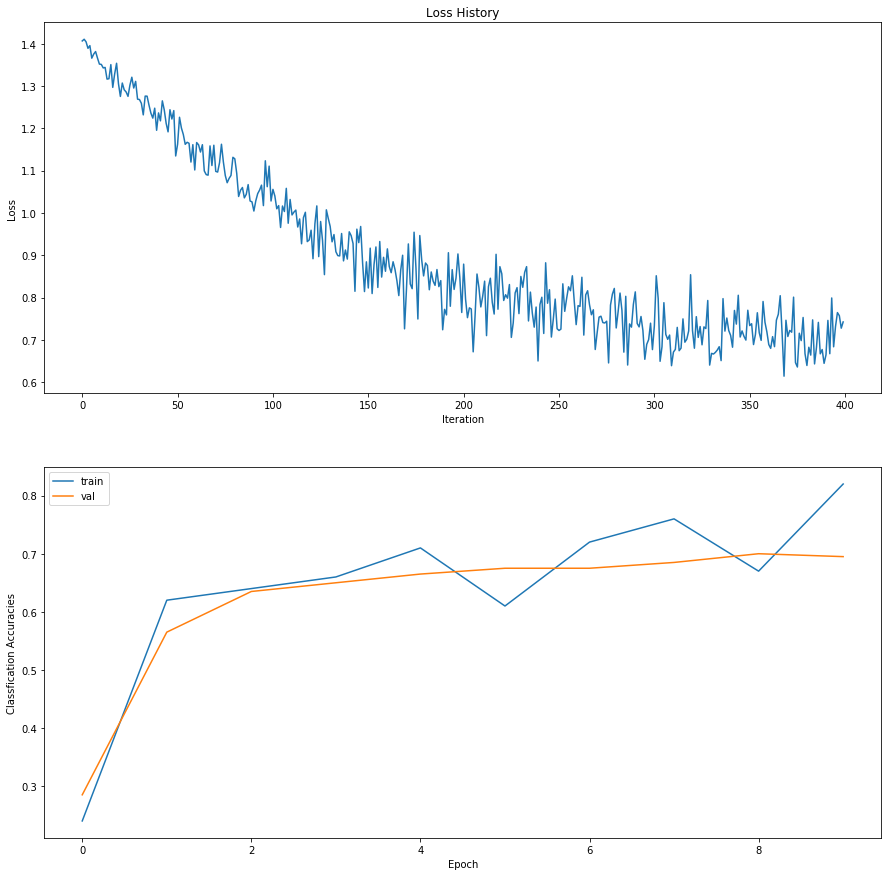

In [28]:
# loss history
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.subplot(2, 1, 1) 
plt.plot(history_data['loss_hist'])
plt.title('Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2,1,2)
plt.plot(history_data['train_acc_hist'], label='train')
plt.plot(history_data['val_acc_hist'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Classfication Accuracies')
plt.legend()
plt.show()

In [0]:
# function to predict a random image
def predict_image():
  img_idx = random.randint(0, len(y_dev))
  plt.imshow((X_dev[img_idx] + mean_image).reshape(width, height, channel).astype('uint8'))
  plt.show()
  
  result = model.predict(X_dev[i].reshape(-1, X_dev[img_idx].shape[0]))
  print('Prediction: ', classes[np.asscalar(result)], ' Real: ', classes[y_dev[img_idx]])

In [0]:
plt.rcParams['figure.figsize'] = (11.0, 9.0)

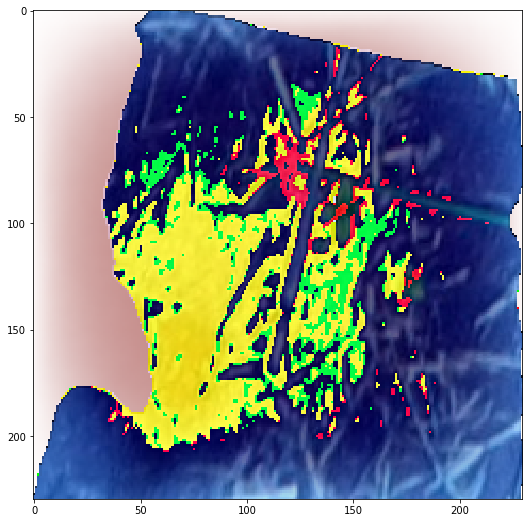

Prediction:  soil  Real:  soil


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  import sys


In [48]:
predict_image()

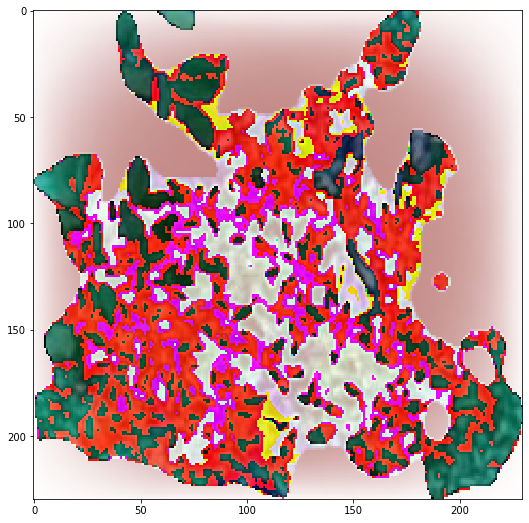

Prediction:  soil  Real:  broadleaf


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  import sys


In [50]:
predict_image()